# BOSS Bright Sky - Using Spframe Flux

Using the BOSS sky spectra we can investigate the SNR calculations for the BGS survey on DESI. We want to confirm that we believe the model being used to determine exposure times for the bright time.

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [15]:
import os, glob, sys, fnmatch
import numpy as np
import pandas as pd
import seaborn as sns
import pandas as pd
from astropy.io import fits

import astropy.table
import astropy.units as u
from astropy.time import Time
import corner
import seaborn as sns

import sklearn.linear_model
import specsim.atmosphere
from scipy import interpolate
import statsmodels.api as sm 

from matplotlib.font_manager import FontProperties
font = FontProperties()
font.set_family('serif')
font.set_size('small')

## Sky Continuum

According to the BGS wiki, the maximum number of targets have a redshift of $\approx$0.15. For the 4000 Ang then corresponds to $\approx$460nm. We can use BOSS sky spectra to study the sky brightness in the blue cameras. Below is a plot of the sky spectrum from the BOSS blue spectrograph with the moon up. I take the continuum level between 460-480nm and also from 415 - 430nm and find the mean value of the continuum. I then take the mean continuum level for all sky fibers in a given image to analyze the dependence on parameters such as moon illumination and altitude.

## DESI Simulated Sky Model

I take the mean continuum level between 460 and 480 nm from the spframe sky flux files for each sky fiber and then take the mean of all sky fibers in a given observation. The flux ('SKY_VALUE') is saved with the metadata associated with that observation in 'good_data.fits'. The following functions then add to this the predicted sky level between 460-480nm from the DESI simulation sky model ('MODEL_SKY').

In [4]:
def opening_angle(ra1, dec1, ra2, dec2):
    # Compute the opening angles between (ra1,dec1) and (ra2,dec2)
    # in degrees using the Haversine formula.
    ra1, ra2 = np.deg2rad(ra1), np.deg2rad(ra2)
    dec1, dec2 = np.deg2rad(dec1), np.deg2rad(dec2)
    havRA12 = 0.5 * (1 - np.cos(ra2 - ra1))
    havDEC12 = 0.5 * (1 - np.cos(dec2 - dec1))
    havPHI = havDEC12 + np.cos(dec1) * np.cos(dec2) * havRA12
    return np.rad2deg(np.arccos(np.clip(1 - 2 * havPHI, -1, +1)))

In [5]:
def unitvec(ra, dec):
    # Return a unit vector aligned with (ra,dec) in degrees.
    ra, dec = np.deg2rad(ra), np.deg2rad(dec)
    cosdec = np.cos(dec)
    return np.array([cosdec * np.cos(ra), cosdec * np.sin(ra), np.sin(dec)])

In [6]:
def at_horizon(raz, decz, ra, dec):
    # Project (ra,dec) into the horizon plane defined by the zenith (raz,decz).
    # Invalid when (ra,dec) points along +/-zenith.
    z = unitvec(raz, decz)
    v = unitvec(ra, dec)
    dot = (z * v).sum(axis=0)
    assert np.all(dot < 1), '(ra,dec) points along +/-zenith'
    return (v - dot * z) / np.sqrt(1 - dot ** 2)

In [7]:
wavelength = np.linspace(3550, 9850, (9850-3550)*10)*u.Angstrom
sky_unit = 1e-17 * u.erg / (u.cm**2 * u.s * u.Angstrom * u.arcsec**2)
area = 1 * u.arcsec ** 2

In [8]:
#moon spectrum
moon_s = np.loadtxt('/Users/parkerf/Research/SkyModel/DESI_Sky/solarspec.txt')
moon_s = interpolate.interp1d(moon_s[:,1], moon_s[:,2])
moon_spectrum = moon_s(wavelength)* u.erg/ (u.cm**2 * u.s * u.Angstrom)

#extinction curve
ext_c = np.loadtxt('/Users/parkerf/Research/SkyModel/DESI_Sky/ZenithExtinction-KPNO.dat')
ext_c = interpolate.interp1d(ext_c[:,0], ext_c[:,1])
extinction_coefficient = ext_c(wavelength)

#surface brightness
surf_bright = np.loadtxt('/Users/parkerf/Research/SkyModel/DESI_Sky/spec-sky.dat')
surf_bright = interpolate.interp1d(surf_bright[:,0], surf_bright[:,1])
surface_brightness_dict = {'dark':surf_bright(wavelength)*sky_unit}

In [9]:
def get_sky_model(data_line):
    """ Defines DESI sky model taken from specsim.atmosphere
    """
    airmass = data_line['AIRMASS']
    moon_zenith = data_line['MOON_ZENITH']*u.deg
    moon_sep = data_line['MOON_SEP']*u.deg
    moon_phase = data_line['MPHASE']
    seeing50 = data_line['SEEING50']*u.arcsec
    
    moon = specsim.atmosphere.Moon(wavelength, moon_spectrum, extinction_coefficient,
            airmass, moon_zenith, moon_sep, moon_phase)
    
    seeing = dict(fwhm_ref=seeing50,
                  wlen_ref=6335*u.Angstrom,
                  moffat_beta=float(3.5))
    
    atmosphere = specsim.atmosphere.Atmosphere(
        wavelength, surface_brightness_dict, extinction_coefficient,
        'yes', 'dark', airmass, seeing, moon)
    
    return atmosphere


In [10]:
def get_continuum(atm_model, lower = 4600, upper = 4800):
    """Measures sky continuum level in sky spectrum created from specsim
    """
    sky = atm_model.surface_brightness.to(sky_unit)*area
    sky = sky.value
    wave = atm_model._wavelength.to(u.Angstrom).value
    idx = np.where((wave > lower)& (wave < upper))
    mean_sky_value = np.mean(sky[idx])
    
    return mean_sky_value

In [16]:
def load_data(filen = '/Users/parkerf/Research/SkyModel/BOSS_Sky/BrightSky/data/good_data.fits'):
    """
    INPUT: files created in bright_moon_cont.py
    The following files can be loaded:
    bright_data.fits: when sky > 2.5*dark sky (defined as 2.78x10^17erg/s/cm2/A)
    dark_data.fits: Sun Alt < -18, Moon Alt < -18
    gray_data.fits: Moon Alt > 0, sky < 2.5*dark sky
    good_data.fits: All sky measurements on BOSS that are 'good'
    
    The files include required meta data and the measured continuum between 460-480nm
    
    OUTPUT: fits table with sky from 460-480nm from DESI sky model included
    """
    data = astropy.table.Table.read(filen)
    moon_zenith = 90-data['MOON_ALT']
    data['MOON_ZENITH'] = astropy.table.Column(moon_zenith.astype(np.float32), unit='deg')
    # Compute the pointing zenith angle in degrees.
    obs_zenith = 90 - data['ALT']
    data['OBS_ZENITH'] = astropy.table.Column(obs_zenith.astype(np.float32), unit='deg')

    mphase = np.arccos(2 * data['MOON_ILL'] - 1) / np.pi
    data['MPHASE'] = astropy.table.Column(mphase.astype(np.float32))
    moon_sep = data['MOON_SEP']
    
    cont_level = [get_continuum(get_sky_model(line)) for line in data]
    
    data['MODEL_SKY'] = astropy.table.Column(np.array(cont_level).astype(np.float32), unit=sky_unit)
    
    return data

data = load_data()

In [11]:
data.dtype.names

('SKY_VALUE',
 'MOON_ILL',
 'MOON_PHASE',
 'FIBER_RA',
 'FIBER_DEC',
 'MJD',
 'TAI-BEG',
 'TAI-END',
 'RA',
 'DEC',
 'AIRMASS',
 'ALT',
 'AZ',
 'EXPTIME',
 'SEEING20',
 'SEEING50',
 'SEEING80',
 'AIRTEMP',
 'DEWPOINT',
 'DUSTA',
 'DUSTB',
 'WINDD25M',
 'WINDS25M',
 'GUSTD',
 'GUSTS',
 'HUMIDITY',
 'PRESSURE',
 'WINDD',
 'WINDS',
 'MOON_LAT',
 'MOON_LON',
 'SUN_LAT',
 'SUN_LON',
 'MOON_ALT',
 'MOON_AZ',
 'SUN_ALT',
 'SUN_AZ',
 'MOON_D',
 'MOON_SEP',
 'SUN_MOON_SEP',
 'SUN_ELONG',
 'DAYS2FULL',
 'ECL_LAT',
 'ECL_LON',
 'GAL_LAT',
 'GAL_LON',
 'AZ_CALC',
 'FLI',
 'SEASON',
 'HOUR',
 'SOLARFLUX',
 'PLATE',
 'IMG',
 'MOON_ZENITH',
 'OBS_ZENITH',
 'MPHASE',
 'MODEL_SKY')

## Defining 'Bright Sky'

The BGS survey will run on DESI when the sky brightness is $> 2.5$ times the brightness of the dark night sky. Grey time is defined as when the moon is above the horizon, but the sky brightness is less than 2.5 times the dark sky brightness. If we take a subset of data that is definitely dark, with airmass $\leq 1.4$, galactic latitude $> 10 ^{\circ}$, and both moon and sun altitude $<-18^{\circ}$, we can define the dark time mean sky brightness. 

In [17]:
def get_dark_data(data = data):
    idx = np.where((data['AIRMASS'] < 1.4) &(data['SUN_ALT'] < -18) & (data['MOON_ALT'] < -18) & (data['GAL_LAT'] > 10))
    dark_data = data[idx]
    return dark_data
dark_data = get_dark_data()

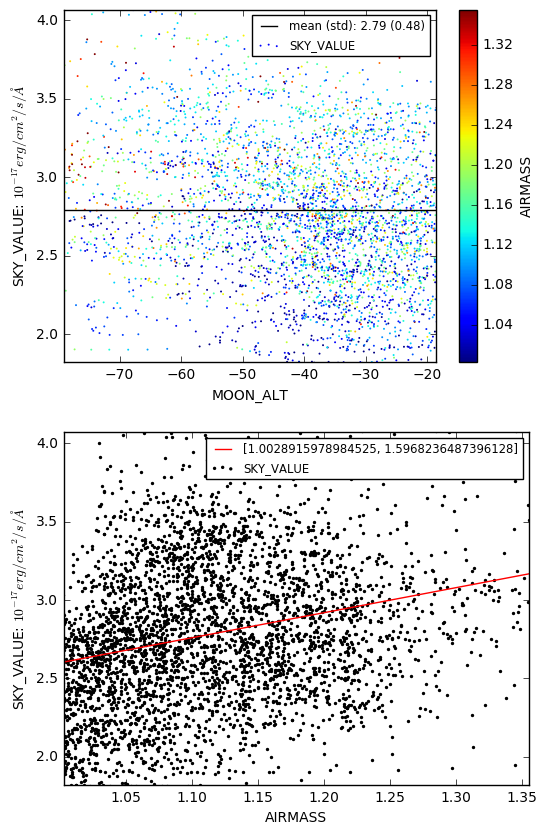

In [18]:
def plot_dark(data=dark_data, xname='AIRMASS', yname='SKY_VALUE', vname='MOON_ALT'):
    x = data[xname]
    y = data[yname]
    v = data[vname]

    xmin, xmax = np.percentile(x, (1, 99))
    ymin, ymax = np.percentile(y, (1, 99))
    vmin, vmax = np.percentile(v, (1, 99))
    
    fig, ax = plt.subplots(2, 1, figsize=(6,10))
    ax = ax.flatten()
    
    s = ax[0].scatter(v, y, s=2, lw=0, c=x, vmin=xmin, vmax=xmax)
    plt.colorbar(s, ax=ax[0]).set_label(xname)
    ax[0].axhline(np.mean(y), color = 'k', label = "mean (std): %.2f (%.2f)" % (np.mean(y), np.std(y)))
    ax[0].set_xlim(vmin, vmax)
    ax[0].set_ylim(ymin, ymax)
    ax[0].set_xlabel(vname)
    ax[0].set_ylabel("%s: $10^{-17} erg/cm^{2}/s/\AA$" % yname)
    ax[0].legend(fontsize = 'small')

    #fit airmass dependence
    x_model = np.linspace(xmin, xmax, 50)
    model = sklearn.linear_model.LinearRegression(fit_intercept=False)
    getX = lambda x: np.vstack((1 + 0*x, x)).transpose()
    model.fit(getX(x), y)
    y_model = model.predict(getX(x_model))
    ax[1].scatter(x, y, s=2, color = 'k')
    ax[1].plot(x_model, y_model, 'r-', label = list(model.coef_))
    
    ax[1].set_xlim(xmin, xmax)
    ax[1].set_ylim(ymin, ymax)
    ax[1].set_xlabel(xname)
    ax[1].set_ylabel("%s: $10^{-17} erg/cm^{2}/s/\AA$" % yname)
    ax[1].legend(fontsize='small')

plot_dark()

Taking the dark sky brightness to be $2.79\times 10^{-17} erg/cm^{2}/s/$Ang, we can then define our gray and bright samples

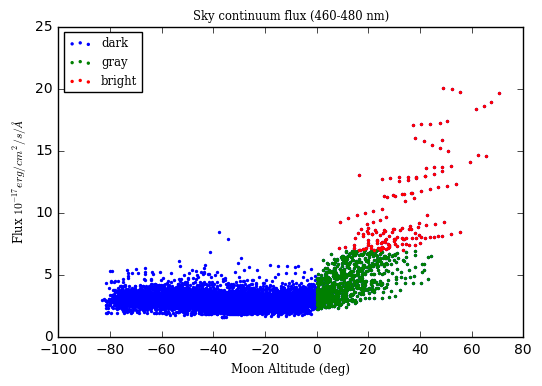

In [19]:
def make_data_dict(data = data, plot = False):
    gray_level = 2.5*2.79
    gray = np.where((data['MOON_ALT']>0)&(data['SKY_VALUE']<gray_level))
    bright = np.where((data['MOON_ALT']>0)&(data['SKY_VALUE']>gray_level))
    dark = get_dark_data()
        
    if plot:
        plt.figure()
        plt.scatter(data['MOON_ALT'], data['SKY_VALUE'], s = 2, color = 'b', label = 'dark')
        plt.scatter(data['MOON_ALT'][gray], data['SKY_VALUE'][gray], s = 2, color = 'g', label = 'gray')
        plt.scatter(data['MOON_ALT'][bright], data['SKY_VALUE'][bright], s = 2, color = 'r', label = 'bright')
        plt.legend(loc='upper left', prop=font)
        plt.xlabel("Moon Altitude (deg)", fontproperties = font)
        plt.ylabel("Flux $10^{-17} erg/cm^{2}/s/\AA$", fontproperties = font)
        plt.title("Sky continuum flux (460-480 nm)", fontproperties = font)
     
    return {'good': data, 'gray': data[gray], 'bright': data[bright], 'dark': dark}

data_dict = make_data_dict(plot=True)

The brightness of the sky depends on Moon Altitude, but also considerably on the Moon illumination fraction

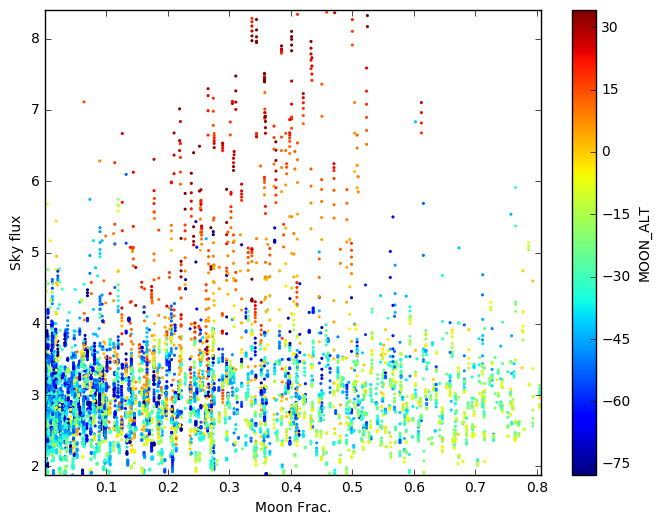

In [20]:
def moon_frac_plot(data = data_dict['good'], xname = 'MOON_ILL', yname='SKY_VALUE', vname='MOON_ALT'):
    x = data[xname]
    y = data[yname]
    v = data[vname]

    xmin, xmax = np.percentile(x, (1, 99))
    ymin, ymax = np.percentile(y, (1, 99))
    vmin, vmax = np.percentile(v, (1, 99))

    mp = data['MOON_ILL']
    gsky = data['SKY_VALUE']
    
    fig, ax = plt.subplots(1, figsize=(8,6))
    s = ax.scatter(x, y,
                      s=5, lw=0, c=v, vmin=vmin, vmax=vmax)
    plt.colorbar(s, ax=ax).set_label(vname)
    ax.set_xlim(np.percentile(mp, (1, 99)))
    ax.set_ylim(np.percentile(gsky, (1, 99)))
    ax.set_xlabel('Moon Frac.')
    ax.set_ylabel('Sky flux')
    
moon_frac_plot()

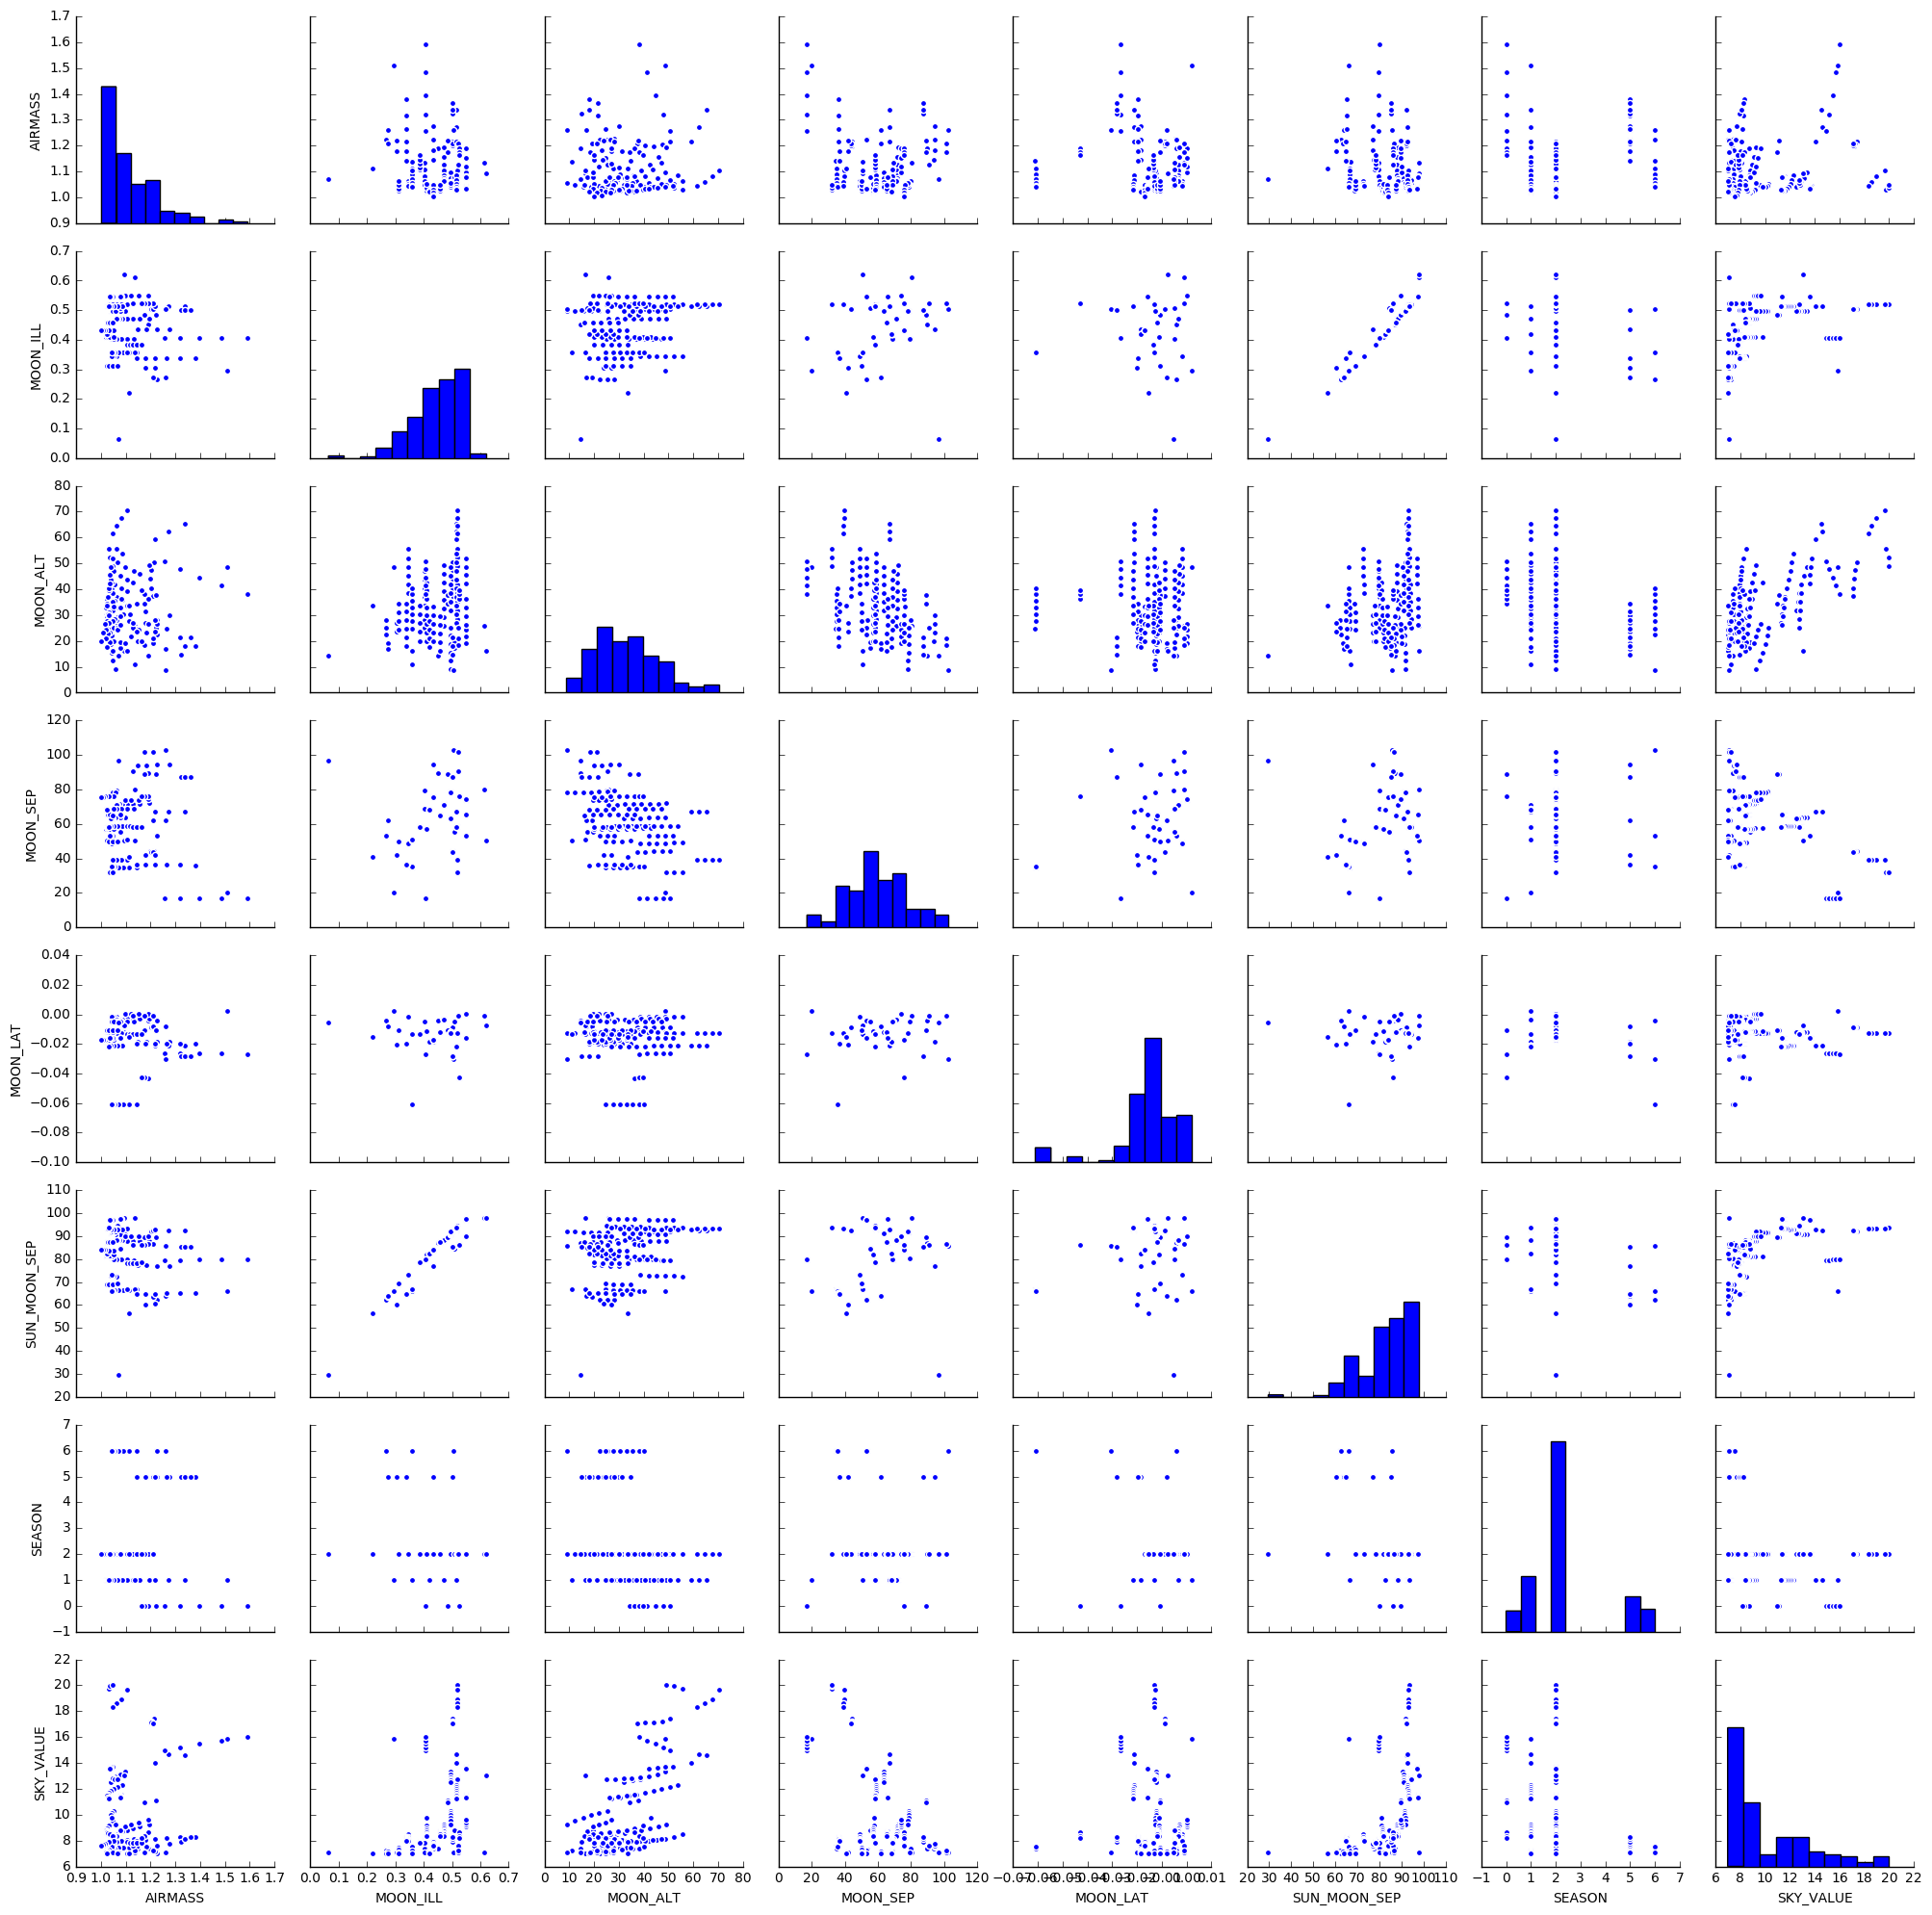

In [21]:
def plot_corner(data=data_dict['bright']):
    fields = ['AIRMASS', 'MOON_ILL', 'MOON_ALT', 'MOON_SEP','MOON_LAT','SUN_MOON_SEP','SEASON','SKY_VALUE']
    plot_data = np.column_stack([data[field] for field in fields])

    df = pd.DataFrame(plot_data, columns = fields)
    sns.pairplot(df)
    
plot_corner()

## Comparing to Model Sky

In [22]:
def model_residuals(data_name = 'dark', xname='MODEL_SKY', vname='MOON_ALT'):
    data = data_dict[data_name]
    sky = data['SKY_VALUE']
    model = data['MODEL_SKY']
    res = sky - model
    
    x = data[xname]
    y = res
    v = data[vname]
    airmass = data['AIRMASS']
        
    # Calculate percentile limits.
    xmin, xmax = np.percentile(x, (1, 99))
    ymin, ymax = np.percentile(y, (1, 99))
    vmin, vmax = np.percentile(v, (1, 99))

    fig, ax = plt.subplots(1, figsize=(8,6))

    s = ax.scatter(x, res, s=5, lw=0, c=v, vmin=vmin, vmax=vmax)
    plt.colorbar(s, ax=ax).set_label(vname)


    ax.set_xlim(xmin, xmax)
    ax.set_xlabel(xname, fontproperties = font)
    ax.set_ylabel('Measured Sky - Model Sky', fontproperties = font)
    ax.set_title("Residual plot for the %s sky model" % data_name, fontproperties = font)

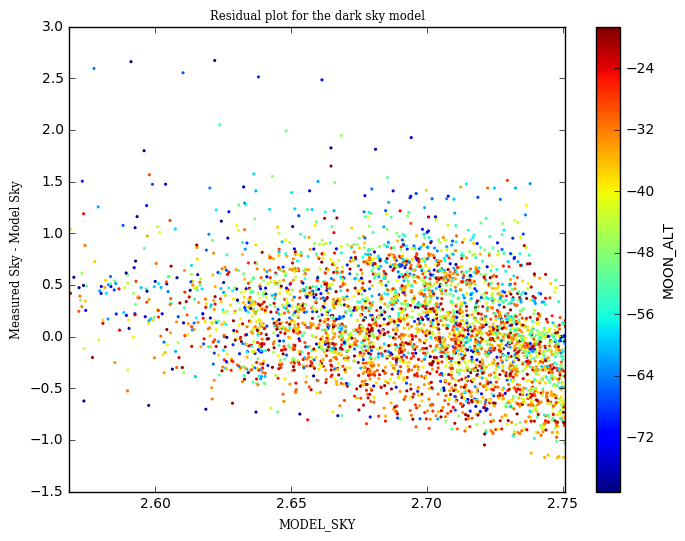

In [23]:
#Tis shows the dark sky model vs. measured flux. The agreement is good.
model_residuals()

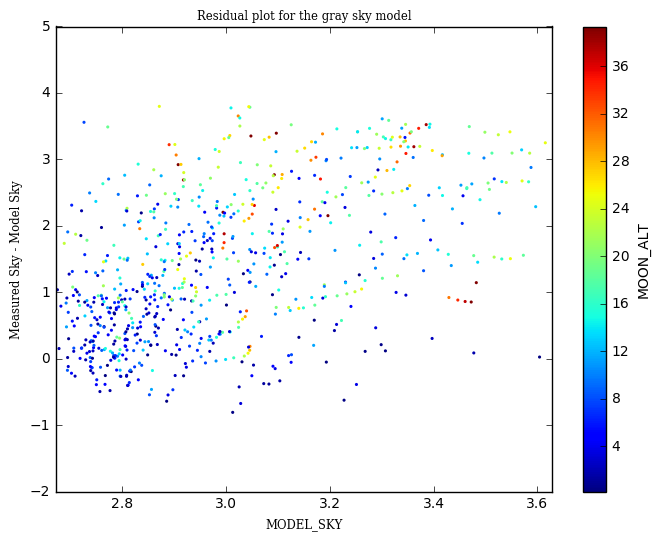

In [24]:
model_residuals(data_name = 'gray')

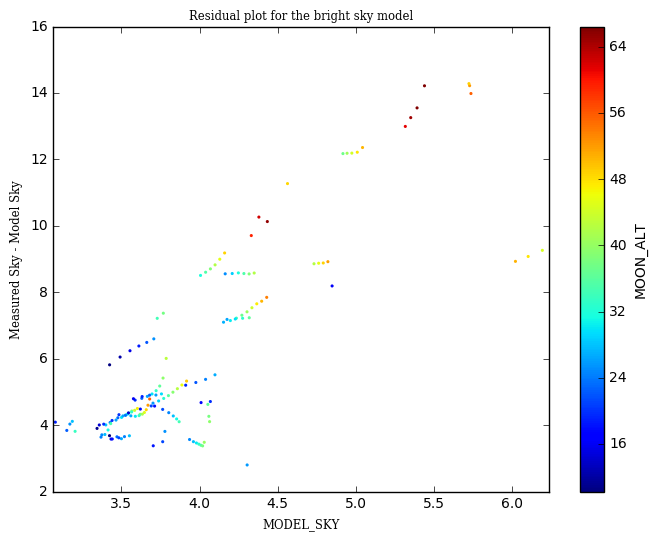

In [25]:
model_residuals(data_name = 'bright')

35

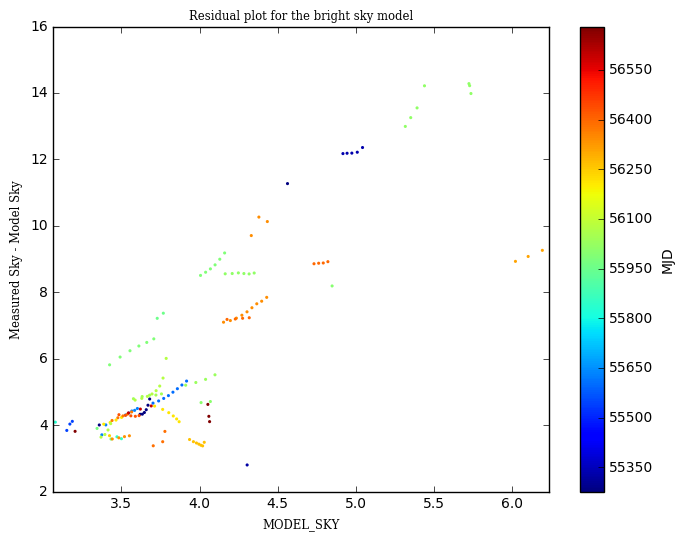

In [26]:
model_residuals(data_name = 'bright',vname='MJD')
len(np.unique(data_dict['bright']['MJD']))

## Twilight Data

[1.0796057799704537, 0.24557733620668515, -0.090935530685032726, 0.018502329705660712]


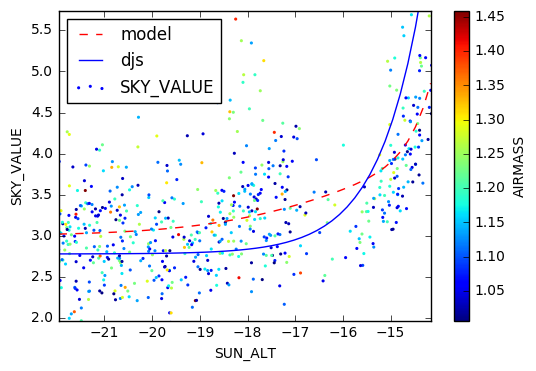

In [36]:
def plot_twilight(data=data_dict['good'], xname='SUN_ALT', yname='SKY_VALUE', vname='AIRMASS'):
    x = data[xname]
    y = data[yname]
    v = data[vname]
    VALID = np.isfinite(x) & np.isfinite(y)
    SEL = VALID & (data['SUN_ALT'] > -22) & (data['MOON_ALT'] < -5) 
    xmin, xmax = np.percentile(x[SEL], (1, 99))
    ymin, ymax = np.percentile(y[SEL], (1, 99))
    vmin, vmax = np.percentile(v[SEL], (1, 99))
    
    fig, ax = plt.subplots(1, figsize=(6,4))
    #ax = ax.flatten()

    s = ax.scatter(x[SEL], y[SEL], s=5, lw=0, c=v[SEL], vmin=vmin, vmax=vmax)
    plt.colorbar(s, ax=ax).set_label(vname)
    
    x_model = np.linspace(xmin, xmax, 50)
    model = sklearn.linear_model.LinearRegression(fit_intercept=False)
    
    dark_sky = 2.78 #10^-17 erg/cm2/s/A
    getX = lambda x: np.vstack((dark_sky + 0*x, 2. ** (18.5 + x), 3. ** (18.5 + x),
                                4. ** (18.5 + x))).transpose()
    model.fit(getX(x[SEL]), y[SEL])
    print(list(model.coef_))
    y_model = model.predict(getX(x_model))
    ax.plot(x_model, y_model, 'r--',label='model')
    
    y_djs = dark_sky + 3 ** (18.5 + x_model) / 30.
    ax.plot(x_model, y_djs, 'b-', label='djs')

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ax.set_xlabel(xname)
    ax.set_ylabel(yname)
    ax.legend(loc='upper left')

plot_twilight()

## Photometric Data Sample

In [27]:
cloud_data = np.load('/Users/parkerf/Research/SkyModel/BOSS_Sky/BrightSky/clouds/phot_rec.npy')
max(data_dict['good']['MJD'])
print(max(cloud_data['MJD']))

56862.0


In [28]:
def get_cloud_data(line):
    df = pd.DataFrame(cloud_data)
    clouds = df[(df['STARTTAI']<= line['TAI-BEG']) & (df['ENDTAI']>line['TAI-BEG'])]['PHOTOMETRIC'].values
    if len(clouds) == 0:
        clouds = df[(df['STARTTAI']< line['TAI-END']) & (df['ENDTAI']>=line['TAI-END'])]['PHOTOMETRIC'].values
    if len(clouds) == 0:
        clouds = 0.5
    
    return clouds

In [29]:
clouds = [get_cloud_data(line) for line in data]

In [30]:
data['PHOTO'] = astropy.table.Column(np.hstack(clouds).astype(np.float32))
data_dict = make_data_dict()

In [31]:
missing_cloud_data = data_dict['good'][data_dict['good']['PHOTO']==0.5]
#print(np.unique(missing_cloud_data['MJD']))
not_missing = [55505.0, 555944, 56341.0,56416.0,56658.0,56659.0,56660.0]
for mjd in not_missing:
    tais = missing_cloud_data[missing_cloud_data['MJD'] == mjd]['TAI-END']
    for tai in tais:
        print("%d:%.2f"%(int(mjd), tai))

55505:4795637681.84
56341:4867873132.85
56341:4867874114.86
56341:4867875096.85
56341:4867876746.85
56341:4867877729.84
56341:4867878711.85
56341:4867879693.86
56341:4867880675.86
56416:4874362790.87
56416:4874363772.87
56416:4874354163.86
56416:4874359282.88
56416:4874360264.87
56416:4874361246.86
56658:4895291444.09
56658:4895292426.10
56658:4895293410.10
56658:4895294392.11
56658:4895295376.08
56658:4895296357.07
56658:4895297341.09
56659:4895377081.10
56659:4895378063.09
56659:4895379045.09
56659:4895380027.08
56659:4895381009.12
56660:4895454993.13
56660:4895455977.11
56660:4895456959.09
56660:4895457940.10
56660:4895450678.12
56660:4895451660.11
56660:4895452642.10


In [32]:
def photometric_cut(data = data):
    phot_data = data[data['PHOTO'] == 1]
    phot_data_dict = make_data_dict(data = phot_data)
    return phot_data_dict
phot_data_dict = photometric_cut()

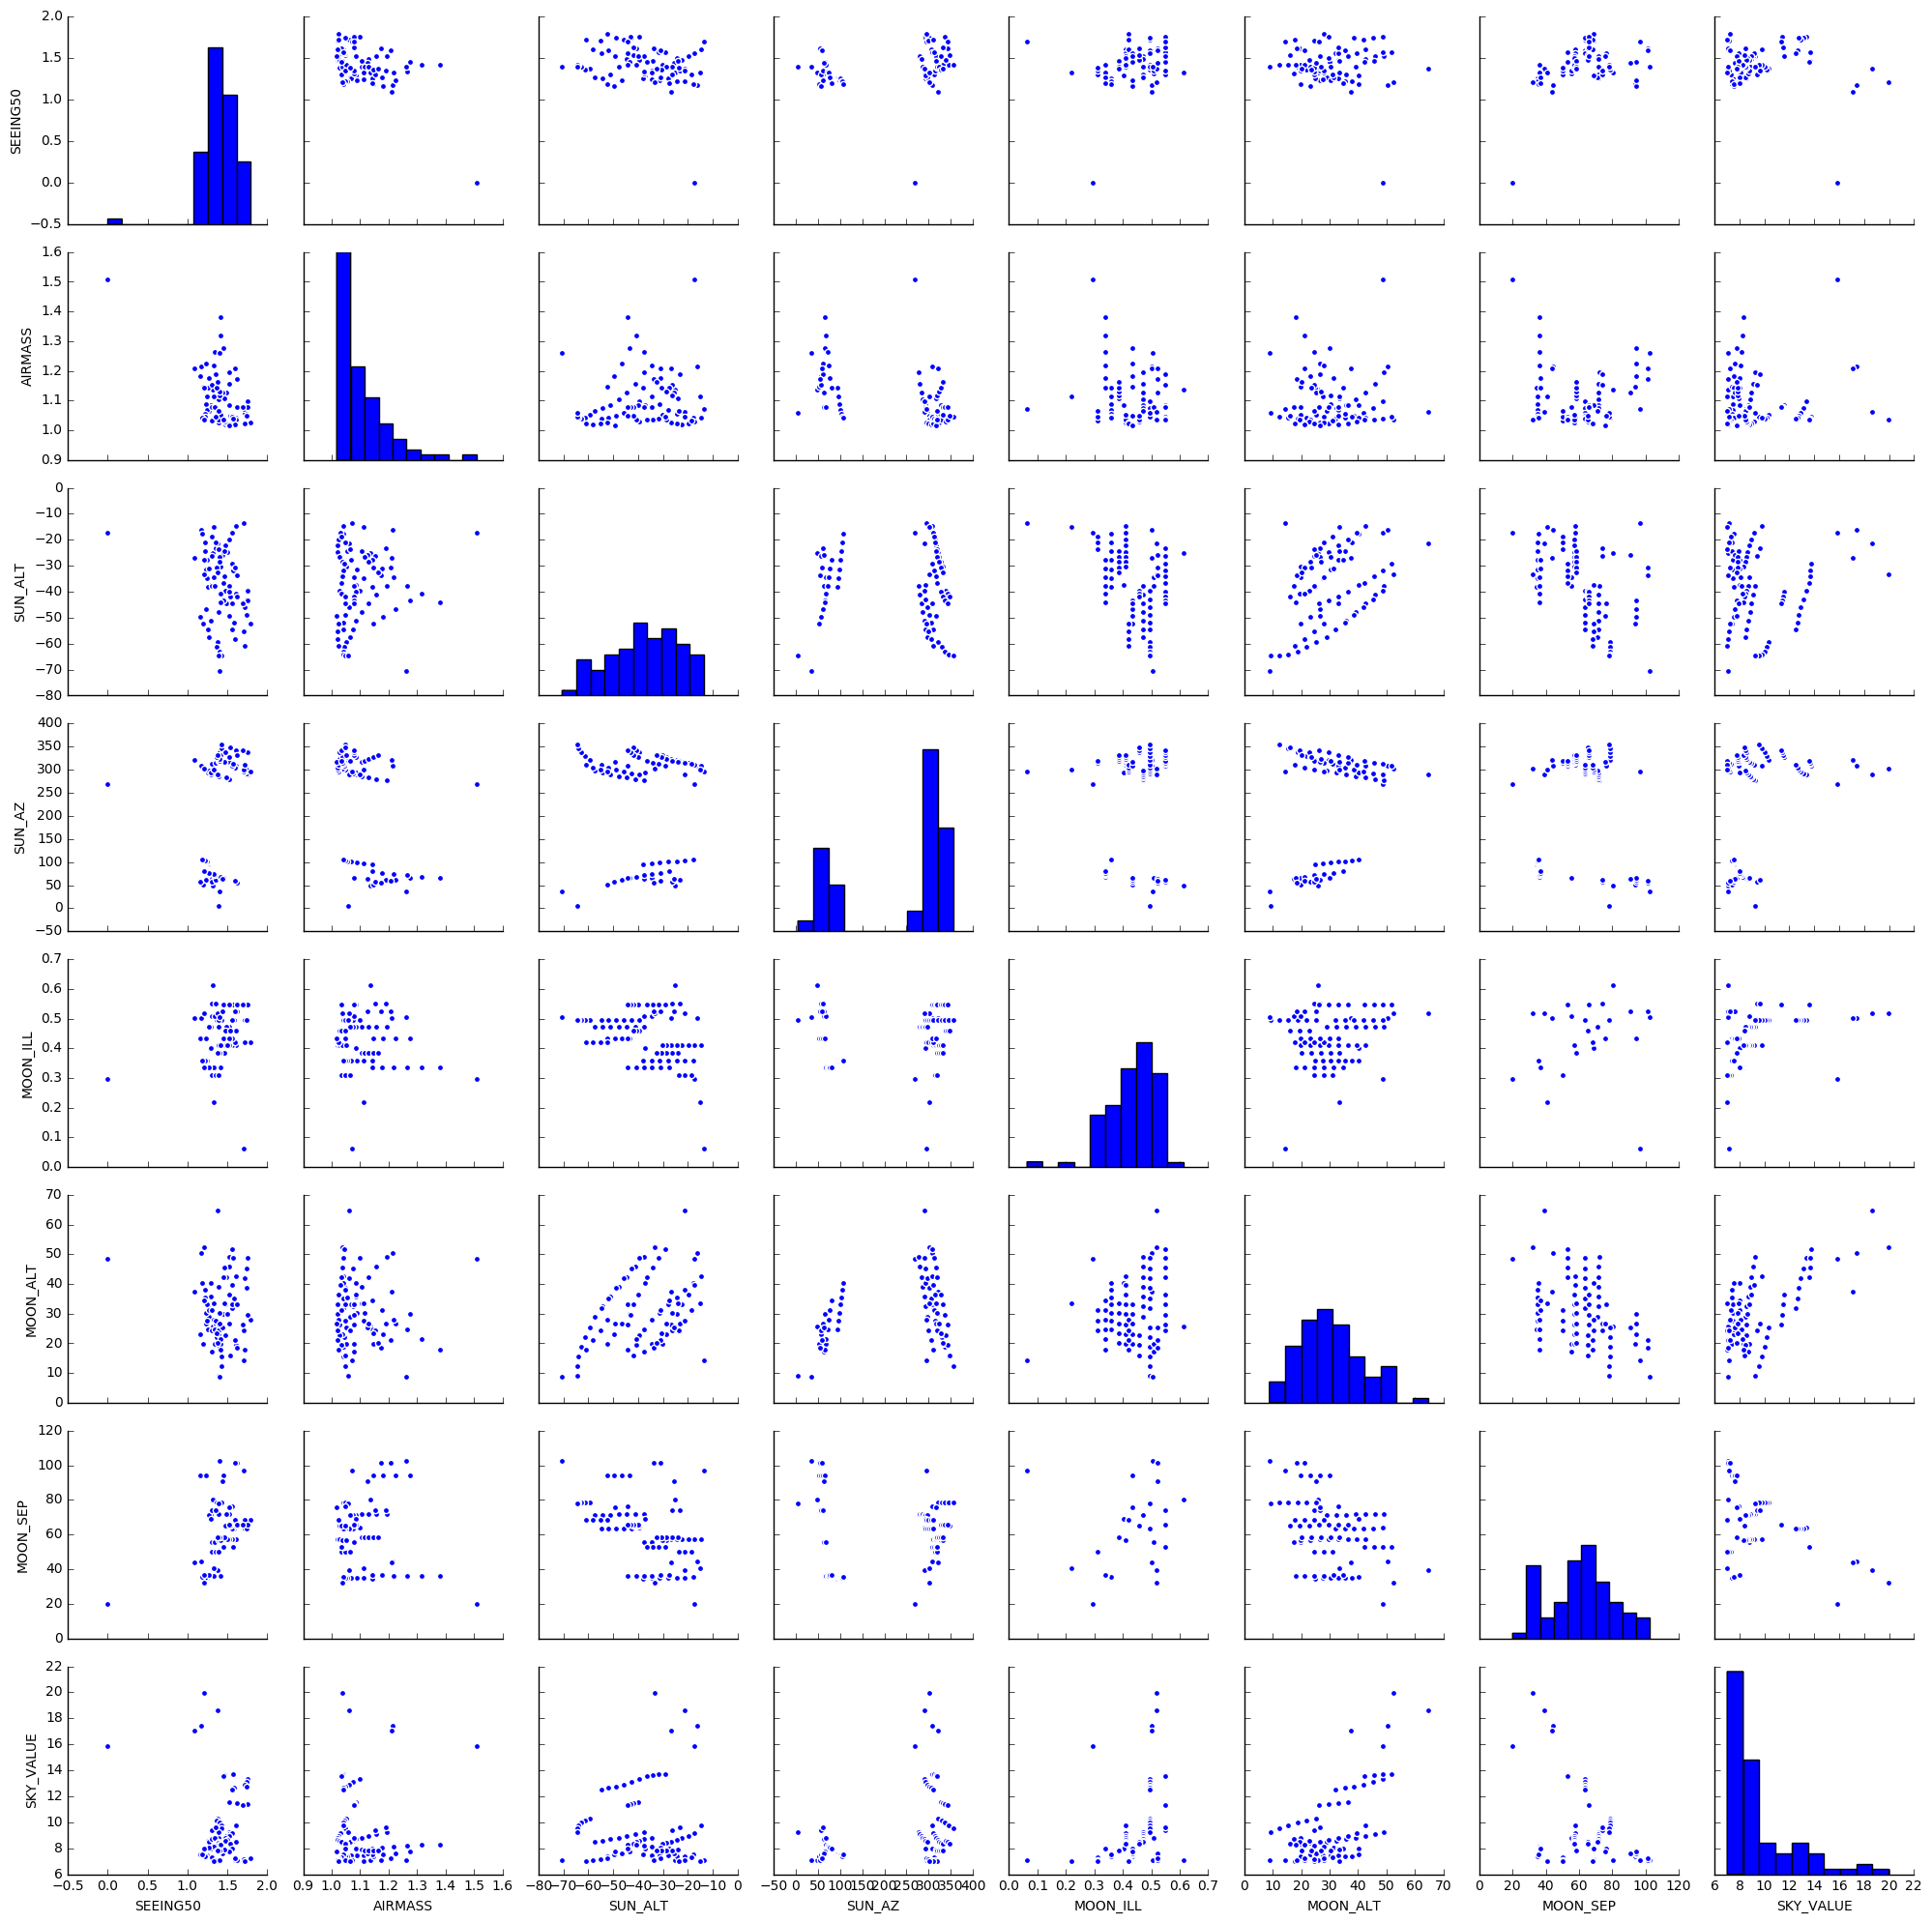

In [37]:
plot_corner(data = phot_data_dict['bright'])

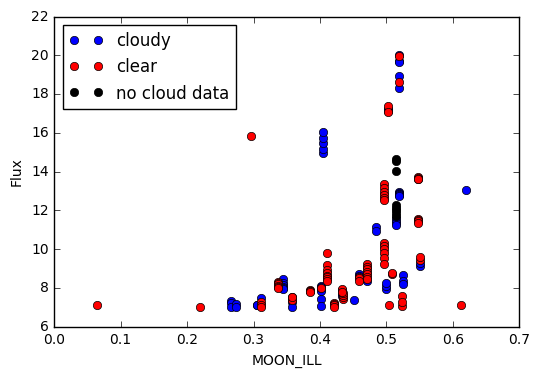

In [33]:
def cloud_plot(name = 'MOON_ILL'):
    cloudy = data_dict['bright'][data_dict['bright']['PHOTO'] == 0]
    clear = data_dict['bright'][data_dict['bright']['PHOTO'] == 1]
    no_data = data_dict['bright'][data_dict['bright']['PHOTO'] == 0.5]
    plt.plot(cloudy[name],cloudy['SKY_VALUE'],'bo',label = 'cloudy')
    plt.plot(clear[name],clear['SKY_VALUE'],'ro', label = 'clear')
    plt.plot(no_data[name],no_data['SKY_VALUE'],'ko', label = 'no cloud data')
    plt.xlabel(name)
    plt.ylabel("Flux")
    plt.legend(loc='upper left')
cloud_plot()

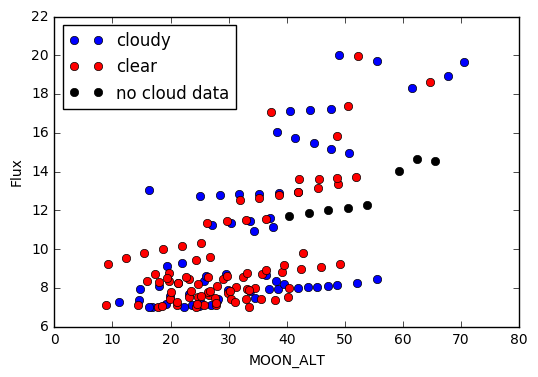

In [34]:
cloud_plot(name='MOON_ALT')

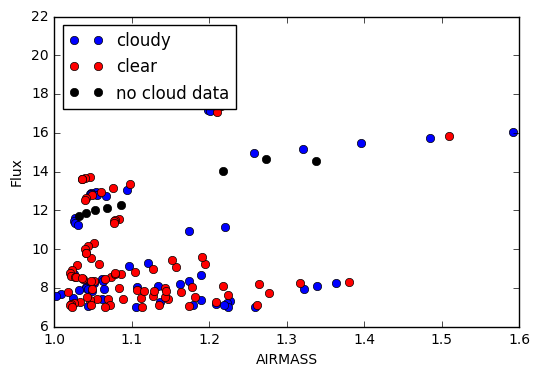

In [35]:
cloud_plot(name='AIRMASS')

## Look at Bright Outliers

In [42]:
bright_df = pd.DataFrame(np.array(data_dict['bright']))
bright_df['LABEL'] = 'regular'
bright_df['LABEL'][(bright_df['PHOTO'] == 0) & (bright_df['SKY_VALUE'] > 14)] = 'BRIGHT_CLOUDY'
bright_df['LABEL'][(bright_df['PHOTO'] == 1) & (bright_df['SKY_VALUE'] > 14)] = 'BRIGHT_CLEAR'
bright_df['LABEL'][(bright_df['PHOTO'] == 1) & (bright_df['SKY_VALUE'] > 3) & (bright_df['SKY_VALUE'] < 14)] = 'REG_CLEAR'
bright_df['LABEL'][(bright_df['PHOTO'] == 0) & (bright_df['SKY_VALUE'] > 3) & (bright_df['SKY_VALUE'] < 14)] = 'REG_CLOUDY'

/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/parkerf/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWar

In [39]:
# Check Logs - Only have Day logs now. Not helpful
for mjd in np.unique(bright_df[bright_df['LABEL'] == 'BRIGHT_CLOUDY'].MJD):
    tt = Time(mjd, format='mjd')
    print(mjd, tt.datetime)
print(np.unique(bright_df[bright_df['LABEL'] == 'BRIGHT_CLOUDY'].PLATE))

55337.0 2010-05-21 00:00:00
56017.0 2012-03-31 00:00:00
56310.0 2013-01-18 00:00:00
[ 4051.  5768.  5783.  6284.]


In [40]:
for mjd in np.unique(bright_df[bright_df['LABEL'] == 'BRIGHT_CLEAR'].MJD):
    tt = Time(mjd, format='mjd')
    print(mjd, tt.datetime)
print(np.unique(bright_df[bright_df['LABEL'] == 'BRIGHT_CLEAR'].PLATE))

55247.0 2010-02-20 00:00:00
55337.0 2010-05-21 00:00:00
56017.0 2012-03-31 00:00:00
[ 3651.  4051.  5768.  5783.]


In [134]:
np.unique(bright_df[bright_df['LABEL'] == 'REG_CLEAR'].MJD)

array([ 55321.,  55603.,  55632.,  55987.,  56001.,  56030.,  56041.,
        56046.,  56074.,  56075.,  56209.,  56210.,  56238.,  56269.,
        56340.,  56370.,  56385.,  56429.,  56781.])

In [136]:
np.unique(bright_df[bright_df['LABEL'] == 'REG_CLOUDY'].MJD)

array([ 55277.,  55278.,  55541.,  55603.,  55632.,  55836.,  55856.,
        55973.,  56030.,  56046.,  56074.,  56370.,  56592.,  56681.])

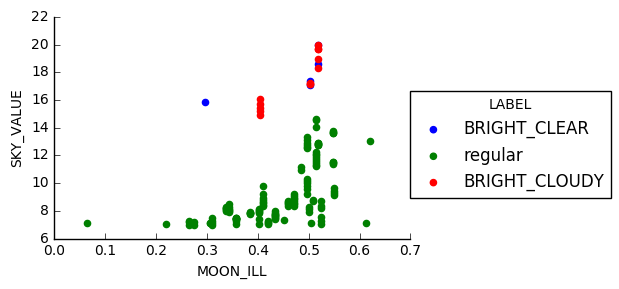

In [69]:
f = sns.FacetGrid(data = bright_df, hue = 'LABEL', aspect = 1.5)
f.map(plt.scatter, 'MOON_ILL', 'SKY_VALUE').add_legend()

In [73]:
meta = np.load("/Users/parkerf/Research/SkyModel/BOSS_Sky/Analysis/MetaData/good_meta_rich.npy")


In [88]:
DATA_DIR = "/Volumes/PFagrelius_Backup/sky_data/sky_flux/"
spframe_files = glob.glob(DATA_DIR+'*_calibrated_sky.npy')

In [100]:
def check_outlier_data(plate,image): 
    my_file = fnmatch.filter(spframe_files,"*%d*"%plate)[0]
    my_meta = meta[(meta['PLATE'] == plate)&(meta['IMG'] == image)]
    my_data = np.load(my_file)
    this_meta = my_meta[(my_meta['CAMERAS'] == b'b1')|(my_meta['CAMERAS'] == b'b2')]
    plt.figure()
    for specno in this_meta['SPECNO']:
        data = my_data[specno]
        plt.plot(data['WAVE'], data['SKY'], label = specno)
    plt.ylim(0,100)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel("Flux")
    plt.title("Sky fibers from plate %d, image %d" % (plate, image))

### Look at Bright/Cloudy Nights

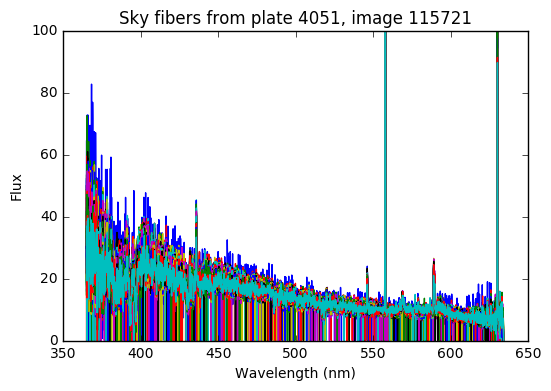

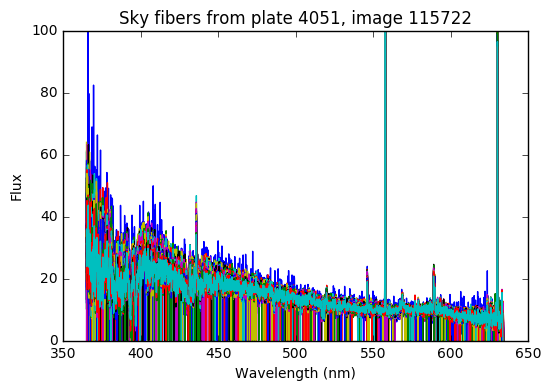

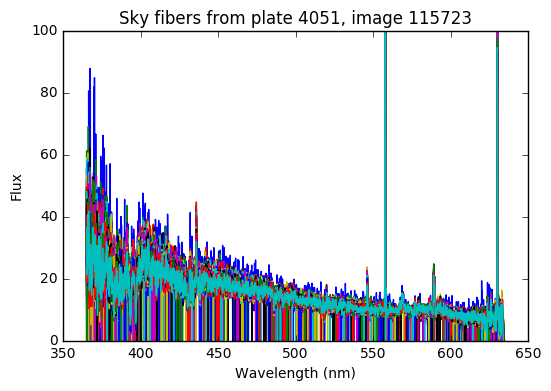

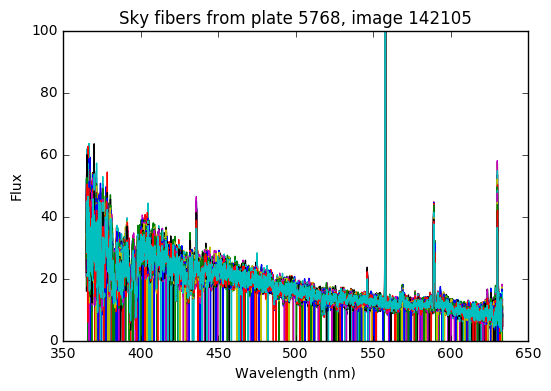

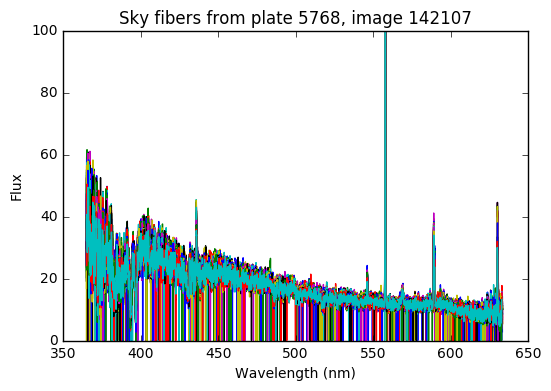

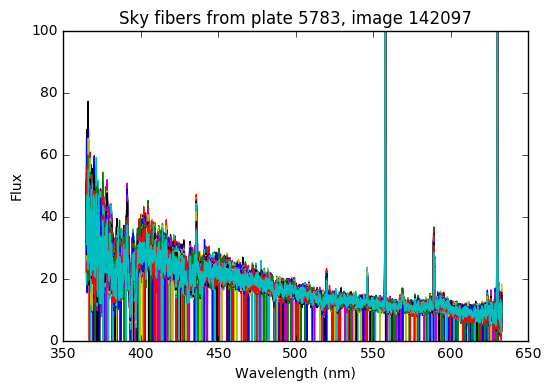

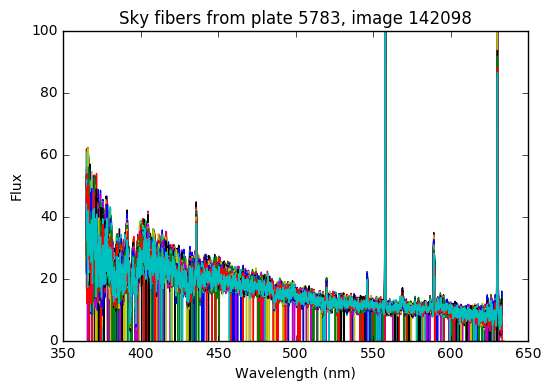

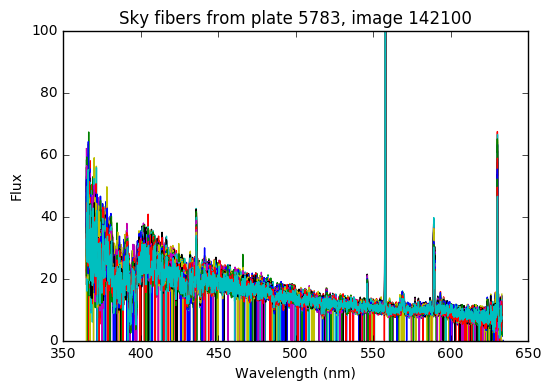

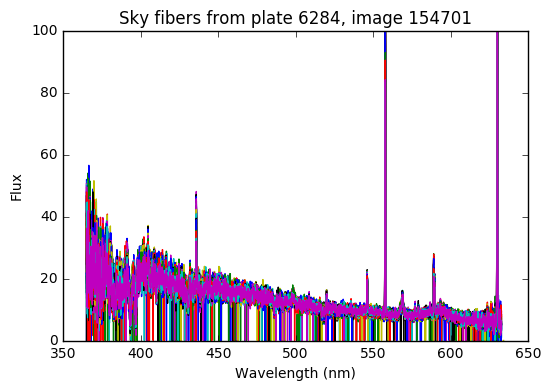

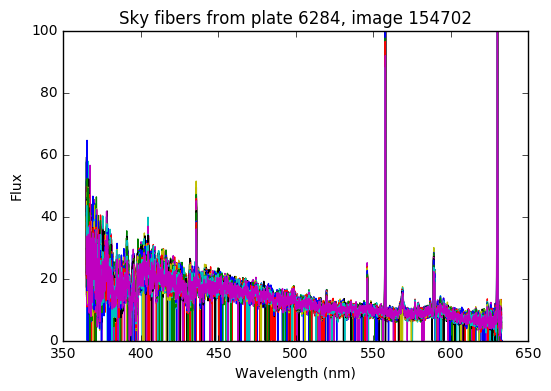

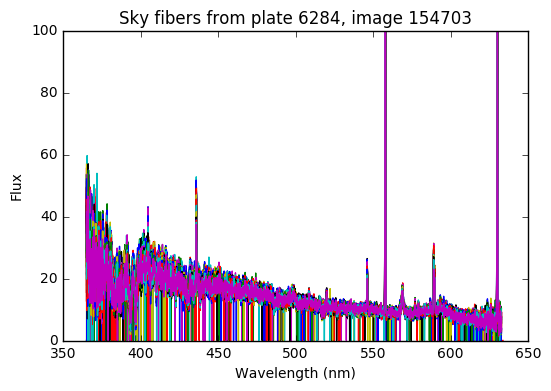

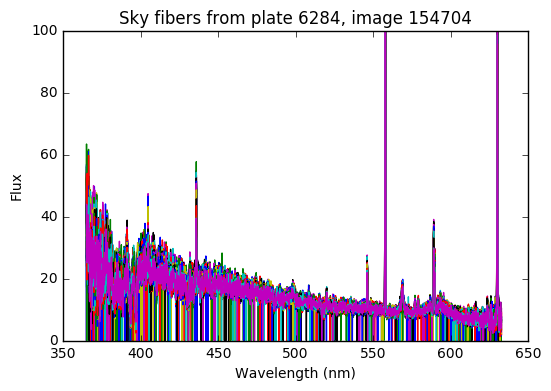

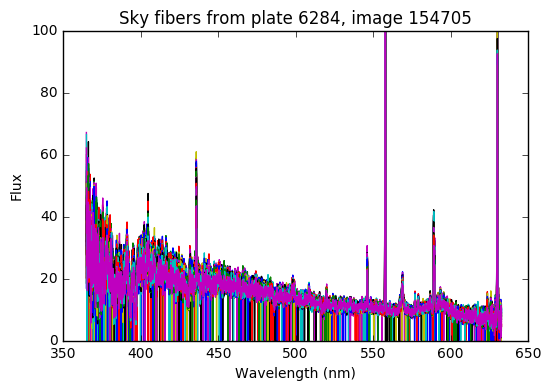

In [101]:
#Look at actual flux
for plate, image in np.array(bright_df[bright_df['LABEL'] == 'BRIGHT_CLOUDY'][['PLATE','IMG']]):
    check_outlier_data(int(plate), int(image))

In [104]:
# Look at variance plots
def var_plots(mjd): 
    filen = "/Users/parkerf/Research/SkyModel/BOSS_Sky/BrightSky/bright_cloudy_data/ircam-variance-%d.fits" % int(mjd)
    hdu = fits.open(filen)
    var_data = hdu[1].data
    plt.figure()
    plt.plot(var_data['TAI'],var_data['VARIANCE'])
    plt.xlabel("TAI")
    plt.ylabel("Variance")
    plt.title("MJD: %d" % mjd)

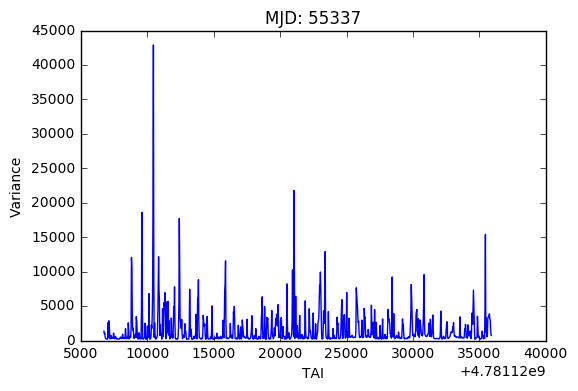

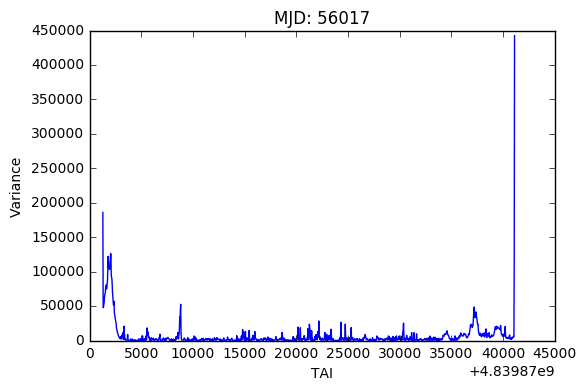

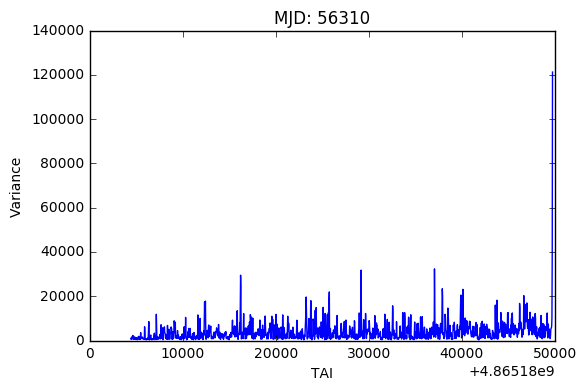

In [105]:
for mjd in np.unique(bright_df[bright_df['LABEL'] == 'BRIGHT_CLOUDY'].MJD):
    var_plots(int(mjd))

                                 OBSERVING LOG
                             Thursday May 20, 2010

                                  (MJD 55337)

---=== OBSERVING SUMMARY ===---

Crystal clear night with excellent seeing (except for a few minutes at the end of the night).

Observed:
        *Cart 11, plate 4051 (DONE)
        *Cart 12, plate 4025
        *Cart 14, plate 4010
        Cart 17, plate 3932 (DONE)
        Cart 16, plate 3925

Even though the conditions were perfect, we were only obtaining S/N values of 
~1-1.5 within SOS for both blue cameras for the *ed plates. All hartmanns and collimate values were checked, and all cameras were in or very close to being in focus. Perhaps there is an issue with the plate designs for 4000+ plates? It seems like this is the only thing that is in common.

                       APACHE POINT OBSERVATORY SDSS 2.5M

                                 OBSERVING LOG
                          Friday March 30, 2012

                                  (MJD 56017)


---- Observing Summary ----

Mostly clear night with good seeing and a lot of Moon light.

BOSS plates exposed:
10 5783 - DONE
15 5768 - DONE
13 5362 - DONE
14 5846 - DONE
16 5441 - DONE
17 5483 - DONE
18 5482 - DONE
12 5207 - not done

We collected ~ 36K dust hours, please check dust for optics. 

                       APACHE POINT OBSERVATORY SDSS 2.5M

                                 OBSERVING LOG
                          Thursday January 17, 2013

                                  (MJD 56310)

---- Observing Summary ----

Clear skies with seeing around 2-3" all night. We finished 5 plates and got 4
exposures on the MaNGA plate.


We observed the following plates:

Cart 12, 6171 - 
Cart 17, 6284 - Done
Cart 14, 6272 - 
Cart 11, 5806 - Done
Cart 15, 6466 - Done
Cart 1, 6651 - 4x 20min exposures (d1,d2,d3,d1)
Cart 16, 6415 - Done
Cart 18, 5983 - Done

Red xsigma value on B2 - Cart 17 plate 6284 - Flat 154700

12:58Z - Started APOGEE Morning Cals, Boss 20x Bias and 1x 900s dark

Jon Holtzmann was observing with APOGEE on the 1m.


                       APACHE POINT OBSERVATORY SDSS 2.5M

                                 OBSERVING LOG
                            Friday February 19, 2010

                                  (MJD 55247)

---=== OBSERVING SUMMARY ===---

The night was partly lost due to clouds. But we observed 5 plates. 
Two of them has been declared as done, for the three another we acuumulated
some useful S/N. 
       
13, 3665 DONE, S/N: 14.5   54.0   19.3   38.7   7203.0 
11, 3768 DONE, S/N: 29.2   48.5   26.8   56.4   6301.0 

For the three another we accumulated useful S/N:

10,3651 not done
12,3685 not done
17,3768 not done

At the morning we switched interlock to minimum mode 
for the outside manipulator

In [110]:
# Look at Sky Camera images
bright_df[bright_df['LABEL'] == 'BRIGHT_CLOUDY'][['MJD','TAI-BEG']]

,MJD,TAI-BEG
10,55337.0,4.781130e+09
11,55337.0,4.781131e+09
12,55337.0,4.781132e+09
79,56017.0,4.839883e+09
81,56017.0,4.839885e+09
82,56017.0,4.839878e+09
83,56017.0,4.839879e+09
85,56017.0,4.839881e+09
110,56310.0,4.865193e+09
111,56310.0,4.865194e+09


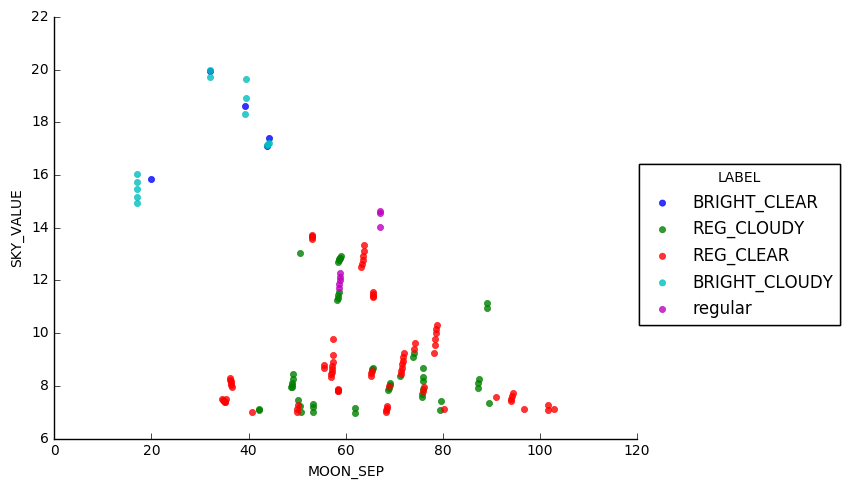

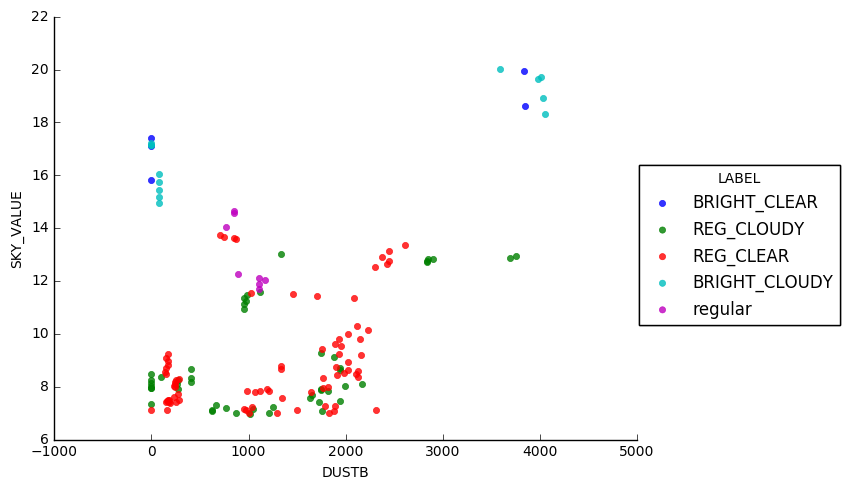

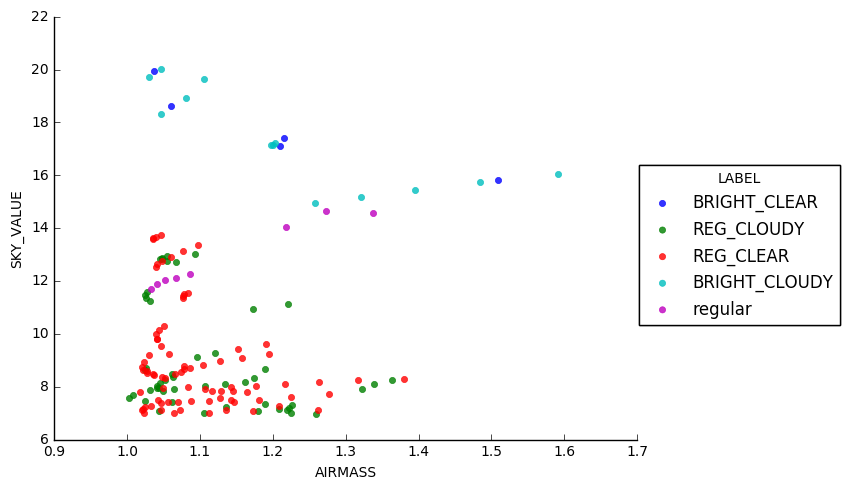

In [50]:
for feature in ['MOON_SEP','DUSTB', 'AIRMASS']:
    sns.lmplot( data = bright_df,x= feature, y='SKY_VALUE', hue = 'LABEL',fit_reg=False).add_legend()

## Towards an improved Bright Sky Model

For starters, we can just run a linear model based on relevant parameters

(157, 15) (157,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.984
Method:                 Least Squares   F-statistic:                     655.1
Date:                Thu, 11 Jan 2018   Prob (F-statistic):          5.99e-123
Time:                        16:46:09   Log-Likelihood:                -260.85
No. Observations:                 157   AIC:                             551.7
Df Residuals:                     142   BIC:                             597.5
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
MOON_ILL        90.4367     14.

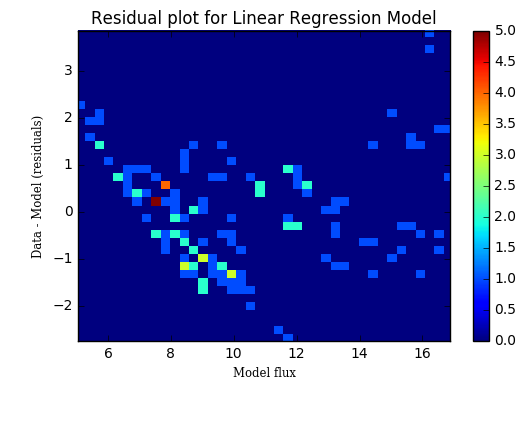

In [147]:
def linear_regression(data_name = 'bright', data_dict = data_dict):
    data = data_dict[data_name]
    #features = ['MOON_ILL','MOON_ALT','MOON_SEP','AIRMASS','AZ','SUN_MOON_SEP','MOON_D','SEEING50']
    features = ['MOON_ILL','MOON_ALT','MOON_SEP','AIRMASS','SUN_MOON_SEP','MOON_D','RA','DEC',
                'ECL_LON','ECL_LAT','GAL_LAT','GAL_LON','SEASON','HOUR','MOON_AZ']

    X = []
    for feat in features:
        X.append(data[feat])
    X = np.column_stack(X)

    y = data['SKY_VALUE']
    print(X.shape, y.shape)

    sm.OLS.exog_names = features
    results = sm.OLS(y, X).fit()

    params = results.params
    model = np.dot(X, params)
    
    print(results.summary())
    

    xmin, xmax = np.percentile(model, (1, 99))
    ymin, ymax = np.percentile(y - model, (1, 99))
    plt.hist2d(model, y-model,bins=(50,50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel("Model flux",fontproperties=font)
    plt.ylabel("Data - Model (residuals)",fontproperties=font)
    plt.title("Residual plot for Linear Regression Model")
linear_regression(data_name='bright')

(86, 15) (86,)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     388.2
Date:                Thu, 11 Jan 2018   Prob (F-statistic):           8.32e-62
Time:                        16:46:18   Log-Likelihood:                -128.95
No. Observations:                  86   AIC:                             287.9
Df Residuals:                      71   BIC:                             324.7
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
MOON_ILL       163.1700     19.83

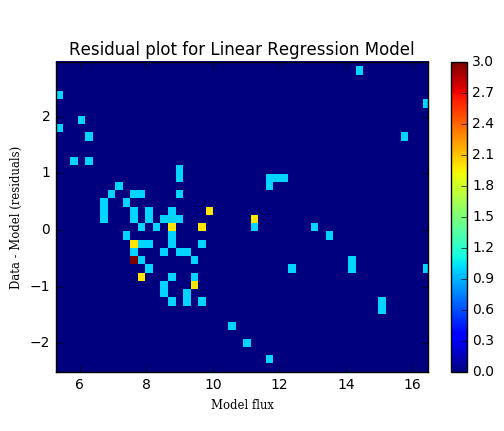

In [148]:
linear_regression(data_name='bright',data_dict = phot_data_dict)

It's clear there's something missing from this model - probably a cloud model to start with. I'm still working on creating a fully representative model.

Since there seems to be a linear relationship between the bright sky model and measured sky, you could just use a correction based on the Moon Alt or actual Modeled Sky. 

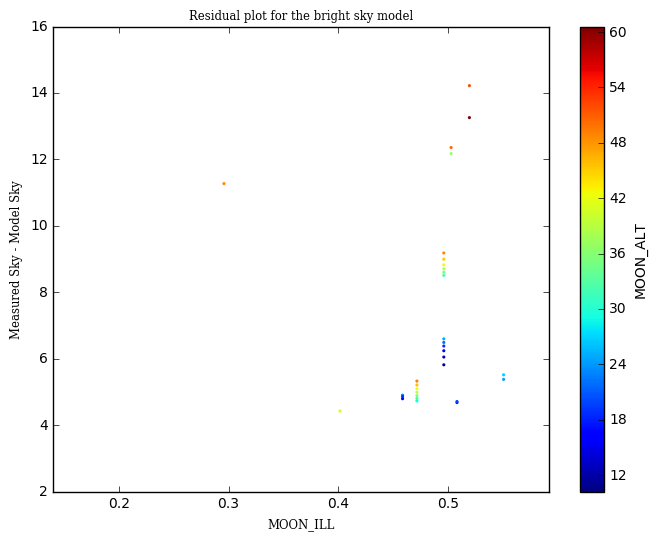

In [99]:
model_residuals(data_name = 'bright', xname='MOON_ILL', vname='MOON_ALT')

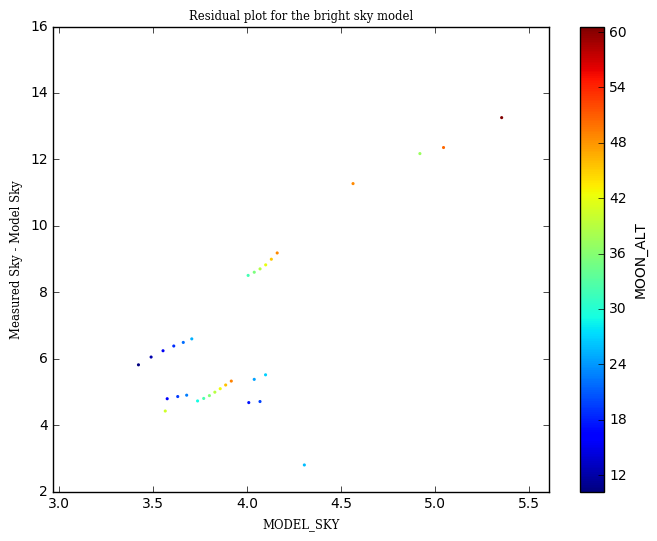

In [100]:
model_residuals(data_name = 'bright', xname='MODEL_SKY', vname='MOON_ALT')

[-9.550443878338621, 5.1133243567801436]


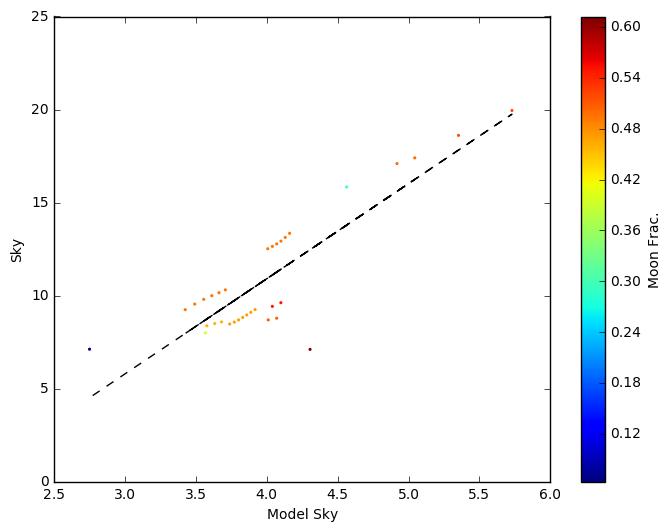

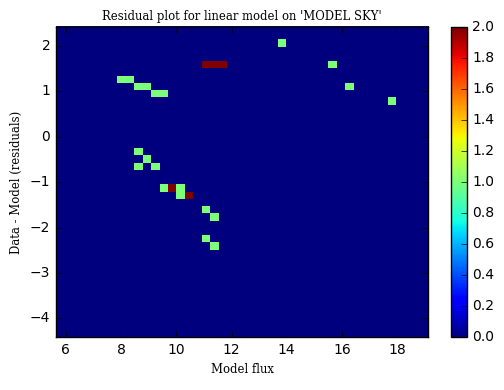

In [101]:
def new_bright_sky_model(data_name = 'bright'):
    data = data_dict[data_name]
    sky = data['SKY_VALUE']
    model = data['MODEL_SKY']
    res = sky - model
    x = data['MODEL_SKY']
    
    fig, ax = plt.subplots(1, figsize = (8,6))
    s = ax.scatter(x, sky, s=5, lw=0, c=data['MOON_ILL'])
    plt.colorbar(s, ax = ax).set_label("Moon Frac.")
    plt.xlabel("Model Sky")
    plt.ylabel("Sky")
    
    #xmin, xmax = np.percentile(x, (1, 99))
    #x_model = np.linspace(xmin, xmax, 50)
    model = sklearn.linear_model.LinearRegression(fit_intercept=False)
    
    getX = lambda x: np.vstack((1 + 0*x, x)).transpose()
    model.fit(getX(x), sky)
    y_model = model.predict(getX(x))
    print(list(model.coef_))
    
    ax.plot(x, y_model, 'k--',label='model')
    
    plt.figure()
    xmin, xmax = np.percentile(y_model, (1, 99))
    ymin, ymax = np.percentile(sky - y_model, (1, 99))
    plt.hist2d(y_model, sky-y_model,bins=(50,50), cmap=plt.cm.jet)
    plt.colorbar()
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)
    plt.xlabel("Model flux",fontproperties=font)
    plt.ylabel("Data - Model (residuals)",fontproperties=font)
    plt.title("Residual plot for linear model on 'MODEL SKY'", fontproperties=font)

    
    return 
new_bright_sky_model()

Bright Sky $= 4.36 \times Model - 7.3 \times 10^{-17} erg/cm^{2}/s/Ang$